# Initial setup (Always run)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from fast_ml.model_development import train_valid_test_split
import pathlib
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from keras.applications.mobilenet import preprocess_input

2.17.0


# Preprocessing 

In [2]:
tsinghua_image_path = os.getcwd()+'/dog_classes'

Define different preprocessing functions

In [9]:
# Function to load and preprocess a single image
# Image is resized, converted to array, and normalised
def parse_image(image_path, target_size=(224, 224)):
    # Load and decode the image
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)  # Convert to array (height, width, channels)

    # Normalize to [0, 1]
    image /= 255.0  # Normalization is often necessary for model training
  
    return image

# Create a function to calculate the mean over the entire dataset
def compute_dataset_mean(image_paths):
    total_sum = np.zeros(3)  # We split into 3, to calculate the pr channel mean - good for deep learning models
    total_count = 0

    for img_path in image_paths:

        full_img_path = os.path.join(tsinghua_image_path, img_path)  # Join the base path with the image path

        parsed_img = parse_image(full_img_path, target_size=(224, 224))

        total_sum += np.mean(parsed_img, axis=(0, 1))  # Mean over width, height for each channel -> we only calculate the mean over the one picture here
        total_count += 1

    dataset_mean = total_sum / total_count
    return dataset_mean

# Compute the feature wise mean (over the whole dataset)
#dataset_mean = compute_dataset_mean(df['Image path'].tolist())
#print("Feature wise Mean: ", dataset_mean)

# Function to apply feature-wise centering
def zero_centering(image, dataset_mean):
    return image - dataset_mean

# Load images into the DataFrame and apply zero-centering
def load_images_into_dataframe(df, dataset_mean):
    # Create a list to hold the processed images
    images = []

    for image_path in df['Image path']:
        full_image_path = os.path.join("dog_classes/", image_path)
        #print(full_image_path)
        image_array = parse_image(full_image_path)  # Load and preprocess the image - is array
        image = zero_centering(image_array, dataset_mean)  # Apply zero centering
        #image /= 255.0
        images.append(image)  # Append the processed image to the list

    # Add the images as a new column in the DataFrame
    df.insert(2, 'Image', images)

    return df

# Load images into the DataFrame
#df = load_images_into_dataframe(df, dataset_mean)

# Now the DataFrame contains paths, labels, and processed images
#df.head(5)


# Visualize data

In [31]:
tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

print('Number of dog breeds: ', len(classes))

#Make empty array to save info about dog breeds and their frequencies
class_names_and_frequencies = []

#Loop through all classes
for class_name in classes:
    class_path = os.path.join(tsinghua_image_path, class_name)
    
    if class_name.startswith('.'):
        print(f"Skipping hidden file: {class_name}")
        continue
    
    dog_name = class_name.split('-')[2] #We only want after the second occurence of "-" in the directory name
    
    
    dog_frequency = len(os.listdir(class_path))
    class_names_and_frequencies.append((dog_name, dog_frequency))

#Get the dataframe
df = pd.DataFrame(class_names_and_frequencies, columns = ['Breeds', 'Frequency'])
print('Total number of images :', df['Frequency'].sum())

Number of dog breeds:  130
Total number of images : 70432


In [32]:
#Check if it looks alright
df.head()

,Breeds,Frequency
0,Shiba_Dog,1043
1,French_bulldog,1121
2,Siberian_husky,1160
3,malamute,1324
4,Pomeranian,1936


<AxesSubplot: title={'center': 'Frequency of dog breeds in descending order'}, xlabel='Frequency', ylabel='Breeds'>

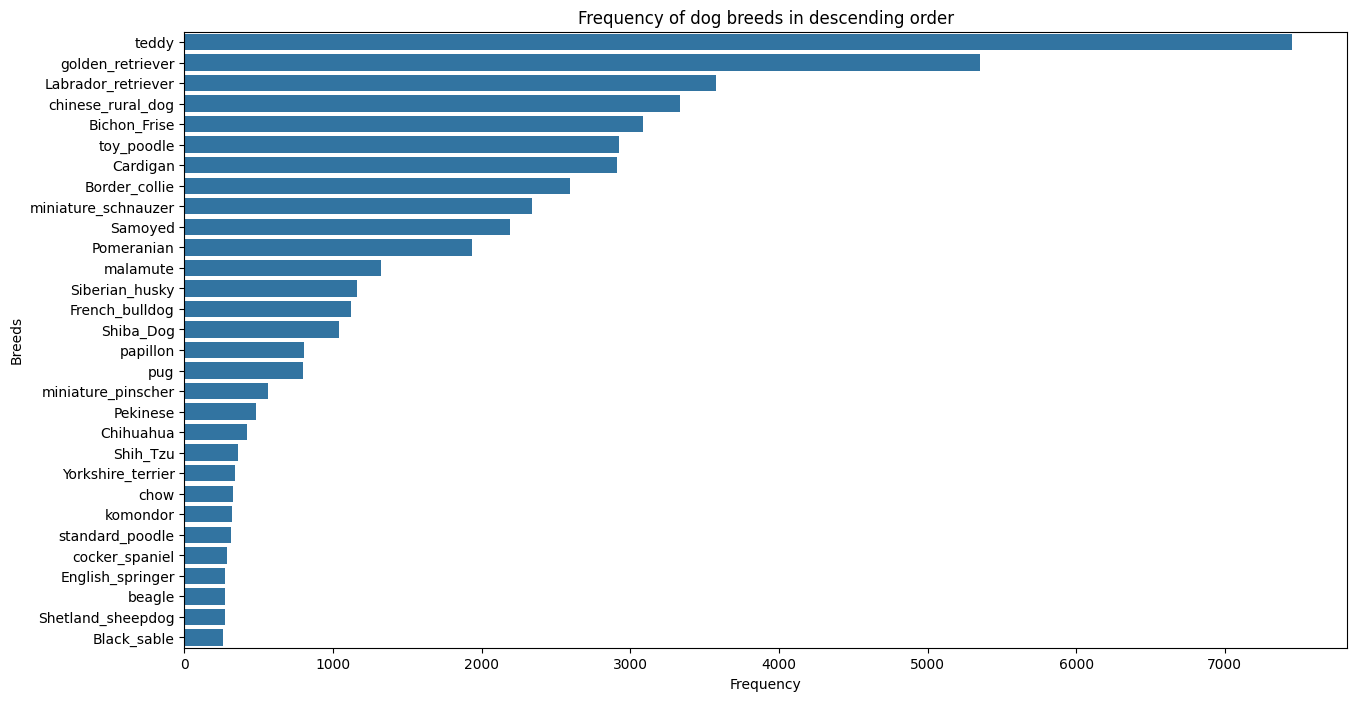

In [33]:
#Plot the distribution of dog breeds
plt.figure(figsize=(15,8))
plt.title('Frequency of dog breeds in descending order')
sns.barplot(x = 'Frequency', y = 'Breeds', data = df.sort_values('Frequency', ascending = False).head(30))

# Preprocessing

Here we load images of (currently 5 classes) into a data frame and apply zero-centering

In [36]:
#Array containing all data
dogs = []

tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

classes = classes[:5]
print("Number of classes to consider: ", len(classes))

for dog_breed in classes:
    if dog_breed.startswith('.'):
        print(f"Skipping hidden file: {dog_breed}")
        continue
    dog_breed_path = os.path.join(tsinghua_image_path, dog_breed)
    for image_id in os.listdir(dog_breed_path):
        path = os.path.join(dog_breed_path, image_id)
        label = dog_breed.split('-')[2]
        dogs.append((path, label))

df = pd.DataFrame(dogs, columns = ['Image path', 'Label'])
print('Shape of dataframe :', df.shape)

df.head()

Number of classes to consider:  5
Shape of dataframe : (6584, 2)


,Image path,Label
0,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,Shiba_Dog
1,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,Shiba_Dog
2,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,Shiba_Dog
3,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,Shiba_Dog
4,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,Shiba_Dog


In [37]:
# Compute the dataset mean
data_mean = compute_dataset_mean(df['Image path'].tolist())
print("Dataset Mean: ", data_mean)

# Make dataframe by applying the mean to zero-center 
df_with_images = load_images_into_dataframe(df, data_mean)

# Now the DataFrame contains paths, labels, and processed images
df.head(5)

Dataset Mean:  [0.52031035 0.48458738 0.44069872]


MemoryError: Unable to allocate 1.15 MiB for an array with shape (224, 224, 3) and data type float64

# Train, validation, and test split

Now we can split the Dataframe, `df`, that contains all our data into training, validation and test sets

In [12]:
# train, test, validation split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_with_images,
                                                                            target = 'Label',
                                                                            train_size=0.6,
                                                                            valid_size=0.2,
                                                                            test_size=0.2)

# Reset the indices of the different sets
for data in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    data.reset_index(drop=True, inplace=True)

In [13]:
# Print the dataset sizes
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


(3950, 2) (3950,)
(1317, 2) (1317,)
(1317, 2) (1317,)


In [14]:
X_train.head(10)

,Image path,Image
0,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[-0.13991818455175775, -0.2728226731926257, ..."
1,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[-0.4144279944630088, -0.37870502727330274, ..."
2,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[0.09537594887300116, -0.1473324696928317, -..."
3,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[0.4757680830626069, 0.4761969347089475, 0.3..."
4,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[0.2757680949835358, 0.3114910621732419, 0.3..."
5,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[0.3267484841017304, 0.3428636093229001, 0.3..."
6,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[-0.04187897470907587, -0.061057965031271644..."
7,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[-0.42227113125042337, -0.36301875369847364,..."
8,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[0.1541994747786103, 0.16247146321236544, 0...."
9,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,"[[[-0.5007025047125043, -0.46497953752279825, ..."


# Model training

Train a basic model

In [16]:
import certifi
print(certifi.where())

c:\Users\theah\AppData\Local\Programs\Python\Python311\Lib\site-packages\certifi\cacert.pem


Load convolutional base

In [17]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Create a new top layer and add it to the conv base

In [18]:
#Number of classes
N=5

# Add new top layer
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

Make convolutional layers "untrainable" such that we only train the decoder

In [20]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


In [38]:
print(df['Label'].apply(lambda x: os.path.exists(x)).value_counts())

Label
False    6584
Name: count, dtype: int64


In [22]:
print("Filepaths exist check:", df['Image path'].apply(lambda x: os.path.exists(x)).value_counts())


Filepaths exist check: Image path
True    6584
Name: count, dtype: int64


In [23]:
# Create an ImageDataGenerator instance
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Using flow_from_dataframe with ImageDataGenerator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image path',              # Column containing file paths
    y_col='Label',                 # Column containing labels
    target_size=(224, 224),         # Resize images to this size
    batch_size=8,
    class_mode='categorical',       # Set to 'categorical' for multi-class labels
    subset='training',              # Define subset as 'training'
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation'             # Define subset as 'validation'
)

Found 5268 validated image filenames belonging to 5 classes.
Found 1316 validated image filenames belonging to 5 classes.


In [24]:
# Set up optimizer
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=1e-6)
#sgd_optimizer = optimizers.SGD(learning_rate=lr_schedule,momentum=0.9, nesterov=True)

sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit(train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Epoch 1/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 74s 103ms/step - accuracy: 0.8496 - loss: 0.3946 - val_accuracy: 0.2043 - val_loss: 6.2201
Epoch 2/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.8750 - loss: 0.1866 - val_accuracy: 0.2500 - val_loss: 5.6837
Epoch 3/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 68s 103ms/step - accuracy: 0.9390 - loss: 0.1568 - val_accuracy: 0.2043 - val_loss: 6.4385
Epoch 4/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - accuracy: 1.0000 - loss: 0.1045 - val_accuracy: 0.7500 - val_loss: 2.3660
Epoch 5/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 68s 103ms/step - accuracy: 0.9491 - loss: 0.1287 - val_accuracy: 0.2043 - val_loss: 6.5351
Epoch 6/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 0.7500 - val_loss: 2.8507
Epoch 7/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 68s 103ms/step - accuracy: 0.9662 - loss: 0.1007 - val_accuracy: 0.2066 - val_loss: 6.5826
Epoch 8/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - accuracy: 0.8750 - loss: 0.180

In [29]:
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)

NameError: name 'x_test' is not defined